In [1]:
# merge two recordings (BL and stimulation) from the same population
# load both datasets, pre-process separately, detect spikes, 
# cluster separately, cluster average spike from BL with average spike from stim

In [2]:
from NewLibraryENG import *

In [3]:
name_data_BL = '2019-01-23T11-19-05PoP1 healthy cortical .h5'
name_data_st = '2019-01-23T16-06-32Pop1 healthy cortical .h5'
name_data_24 = '2019-01-24T16-00-33Pop1 24hour after.h5'

complete_string_BL='/Users/Gaia_1/Desktop/allh5files/healthy/healthy_baseline/'+name_data_BL
complete_string_st='/Users/Gaia_1/Desktop/allh5files/healthy/healthy_stimulation/'+name_data_st
complete_string_24='/Users/Gaia_1/Desktop/allh5files/healthy/healthy 24hrs later/'+name_data_24

In [4]:
#Baseline
data = h5py.File(complete_string_BL,'r')

data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
labels = info_table['Label']
readings_BL = pd.DataFrame(data = data_readings.transpose(), columns = labels)
fs = 10000 #Sampling Frequency
print(readings_BL.shape)

(4222000, 60)


In [5]:
# Stimulation
data = h5py.File(complete_string_st,'r')

data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
labels = info_table['Label']
readings_st = pd.DataFrame(data = data_readings.transpose(), columns = labels)
fs = 10000 #Sampling Frequency
print(readings_st.shape)

(4260000, 60)


In [6]:
#24hrs
data = h5py.File(complete_string_24,'r')

data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
labels = info_table['Label']
readings_24 = pd.DataFrame(data = data_readings.transpose(), columns = labels)
fs = 10000 #Sampling Frequency
print(readings_24.shape)

(4228000, 60)


In [7]:
readings_BL.columns

Index([ b'47',  b'48',  b'46',  b'45',  b'38',  b'37',  b'28',  b'36',  b'27',
        b'17',  b'26',  b'16',  b'35',  b'25', b'Ref',  b'14',  b'24',  b'34',
        b'13',  b'23',  b'12',  b'22',  b'33',  b'21',  b'32',  b'31',  b'44',
        b'43',  b'41',  b'42',  b'52',  b'51',  b'53',  b'54',  b'61',  b'62',
        b'71',  b'63',  b'72',  b'82',  b'73',  b'83',  b'64',  b'74',  b'84',
        b'85',  b'75',  b'65',  b'86',  b'76',  b'87',  b'77',  b'66',  b'78',
        b'67',  b'68',  b'55',  b'56',  b'58',  b'57'],
      dtype='object', name='Label')

In [8]:
inizio=500000
len_data=4220000 #192 secondi
#len_data=len(readings)
ref_BL=readings_BL[b'Ref']
ref_st=readings_st[b'Ref']
ref_24=readings_24[b'Ref']
prova_BL=readings_BL.drop([b'Ref'],axis=1)
prova_st=readings_st.drop([b'Ref'],axis=1)
prova_24=readings_24.drop([b'Ref'],axis=1)
prova_BL=prova_BL.iloc[inizio:len_data, 10:]
prova_BL=prova_BL[b'53']
prova_st=prova_st.iloc[inizio:len_data, 10:]
prova_st=prova_st[b'53']
prova_24=prova_24.iloc[inizio:len_data, 10:]
prova_24=prova_24[b'53']
ref_BL=ref_BL[inizio:len_data]
ref_st=ref_st[inizio:len_data]
ref_24=ref_24[inizio:len_data]

print(prova_BL.shape,ref_BL.shape,prova_st.shape,ref_st.shape,prova_24.shape,ref_24.shape)

(3720000,) (3720000,) (3720000,) (3720000,) (3720000,) (3720000,)


In [9]:
lowcut = 300
highcut = 3000
fs=10000
order=8
b,a=butter_bandpass(lowcut,highcut,fs,order=order)
filt_ref=filtfilt(b,a,ref_BL)
filt_prova=filtfilt(b,a,prova_BL)
f_prova = filt_prova - filt_ref
prova_BL=f_prova

filt_ref=filtfilt(b,a,ref_st)
filt_prova=filtfilt(b,a,prova_st)
f_prova = filt_prova - filt_ref
prova_st=f_prova

filt_ref=filtfilt(b,a,ref_24)
filt_prova=filtfilt(b,a,prova_24)
f_prova = filt_prova - filt_ref
prova_24=f_prova

print(prova_BL.shape,prova_st.shape,prova_24.shape)

(3720000,) (3720000,) (3720000,)


#BL
prova=prova_BL

prova_rows = range(prova.shape[0])
filt_prova = pd.DataFrame(data = 0, columns=prova.columns, index=prova_rows, dtype = "float32")
lowcut = 300
highcut = 3000
fs=10000
order=8
b,a=butter_bandpass(lowcut,highcut,fs,order=order)
filt_ref=filtfilt(b,a,ref_BL)
#ref_df = pd.DataFrame({b'Ref': filt_ref})
for x in tqdm(range(prova.shape[1])):
    filt_prova.values[:,x] = scipy.signal.filtfilt(b, a, prova.values[:,x])
for electrode in prova.columns:
    filt_prova[electrode] = filt_prova[electrode] - filt_ref
#filt_prova = pd.concat([filt_prova, ref_df], axis=1)
prova_BL=filt_prova
prova_BL.shape

#stim
prova=prova_st

prova_rows = range(prova.shape[0])
filt_prova = pd.DataFrame(data = 0, columns=prova.columns, index=prova_rows, dtype = "float32")
lowcut = 300
highcut = 3000
fs=10000
order=8
b,a=butter_bandpass(lowcut,highcut,fs,order=order)
filt_ref=filtfilt(b,a,ref_st)
#ref_df = pd.DataFrame({b'Ref': filt_ref})
for x in tqdm(range(prova.shape[1])):
    filt_prova.values[:,x] = scipy.signal.filtfilt(b, a, prova.values[:,x])
for electrode in prova.columns:
    filt_prova[electrode] = filt_prova[electrode] - filt_ref
#filt_prova = pd.concat([filt_prova, ref_df], axis=1)
prova_st=filt_prova
prova_st.shape

prova_st.index+=1920000
prova_st.index

In [ ]:
mer=pd.concat([prova_BL,prova_st],axis=0)
mer

In [ ]:
mer.index

In [ ]:
switch_index=1920000

In [ ]:
merge=np.concatenate((prova_BL, prova_st), axis=0)
len(merge)

# detection

In [10]:
pos_BL, neg_BL=find_all_spikes(prova_BL)
pos_st, neg_st=find_all_spikes(prova_st)
pos_24, neg_24=find_all_spikes(prova_24)

  0%|          | 0/3710000 [00:00<?, ?it/s]

positive spikes 7103 negative spikes 21818 detected spikes: 28921 firing rate:  77.74462365591398


  0%|          | 0/3710000 [00:00<?, ?it/s]

positive spikes 6224 negative spikes 6436 detected spikes: 12660 firing rate:  34.03225806451613


  0%|          | 0/3710000 [00:00<?, ?it/s]

positive spikes 2707 negative spikes 38171 detected spikes: 40878 firing rate:  109.88709677419355


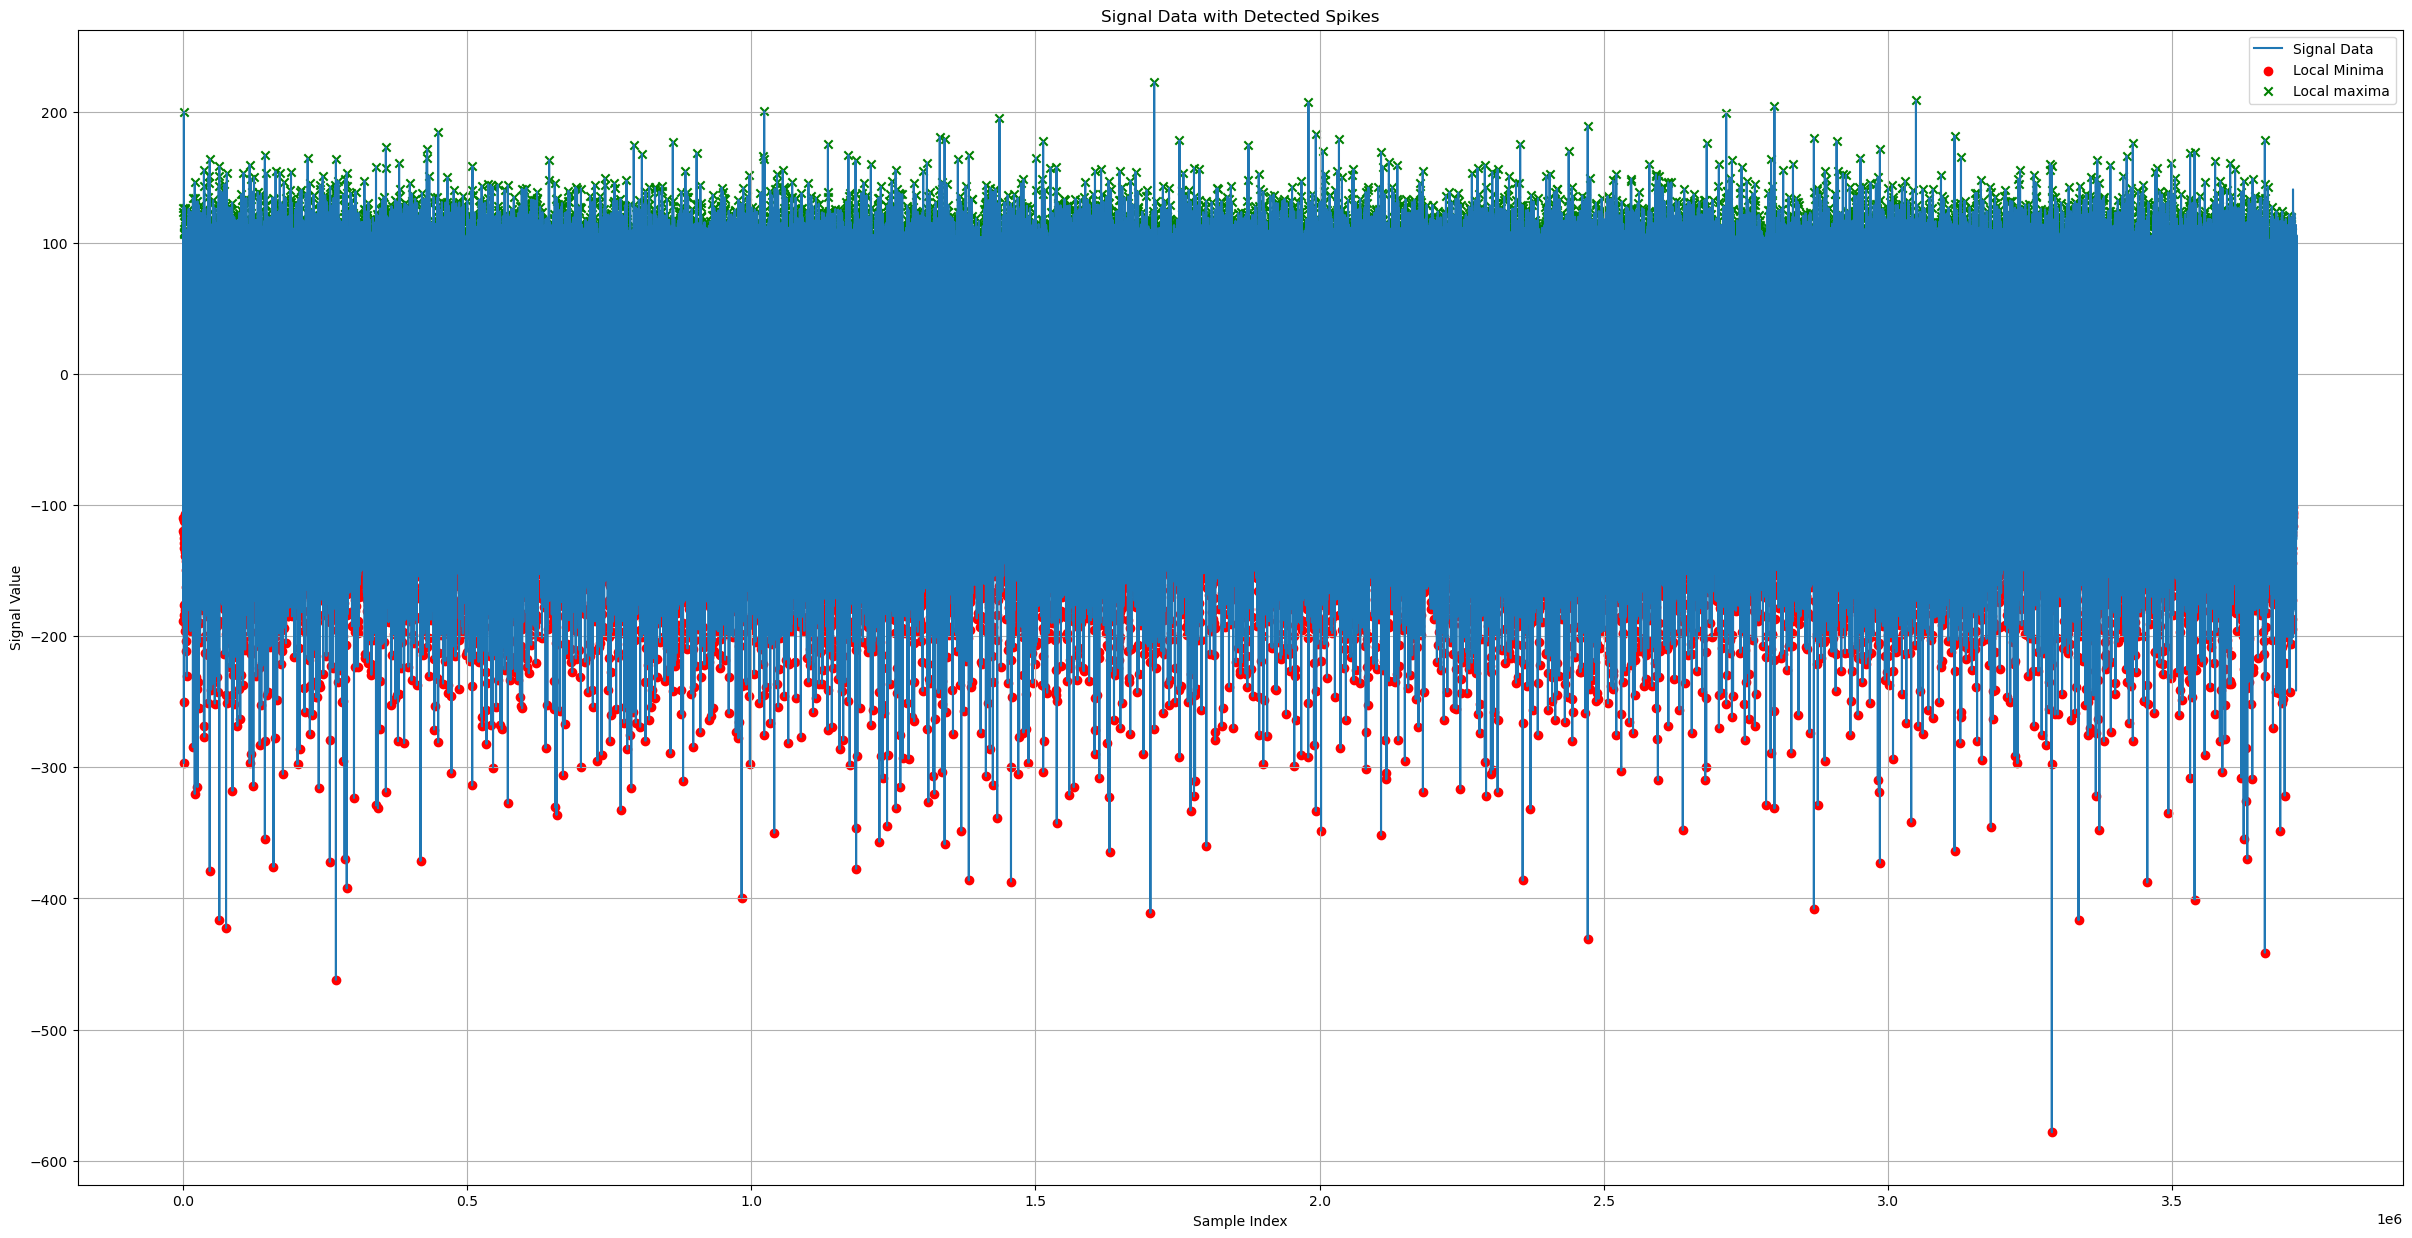

In [22]:
prova=prova_BL
maxima=pos_BL
minima=neg_BL

plt.figure(figsize=(30, 15))
plt.plot(prova, label='Signal Data')
plt.scatter(minima, [prova[i] for i in minima], c='red', marker='o', label='Local Minima')
plt.scatter(maxima, [prova[i] for i in maxima], c='green', marker='x', label='Local maxima')
plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.title('Signal Data with Detected Spikes')
#plt.axis([0,30000,-5,5])
#plt.savefig('spikes2.jpg')
plt.show()

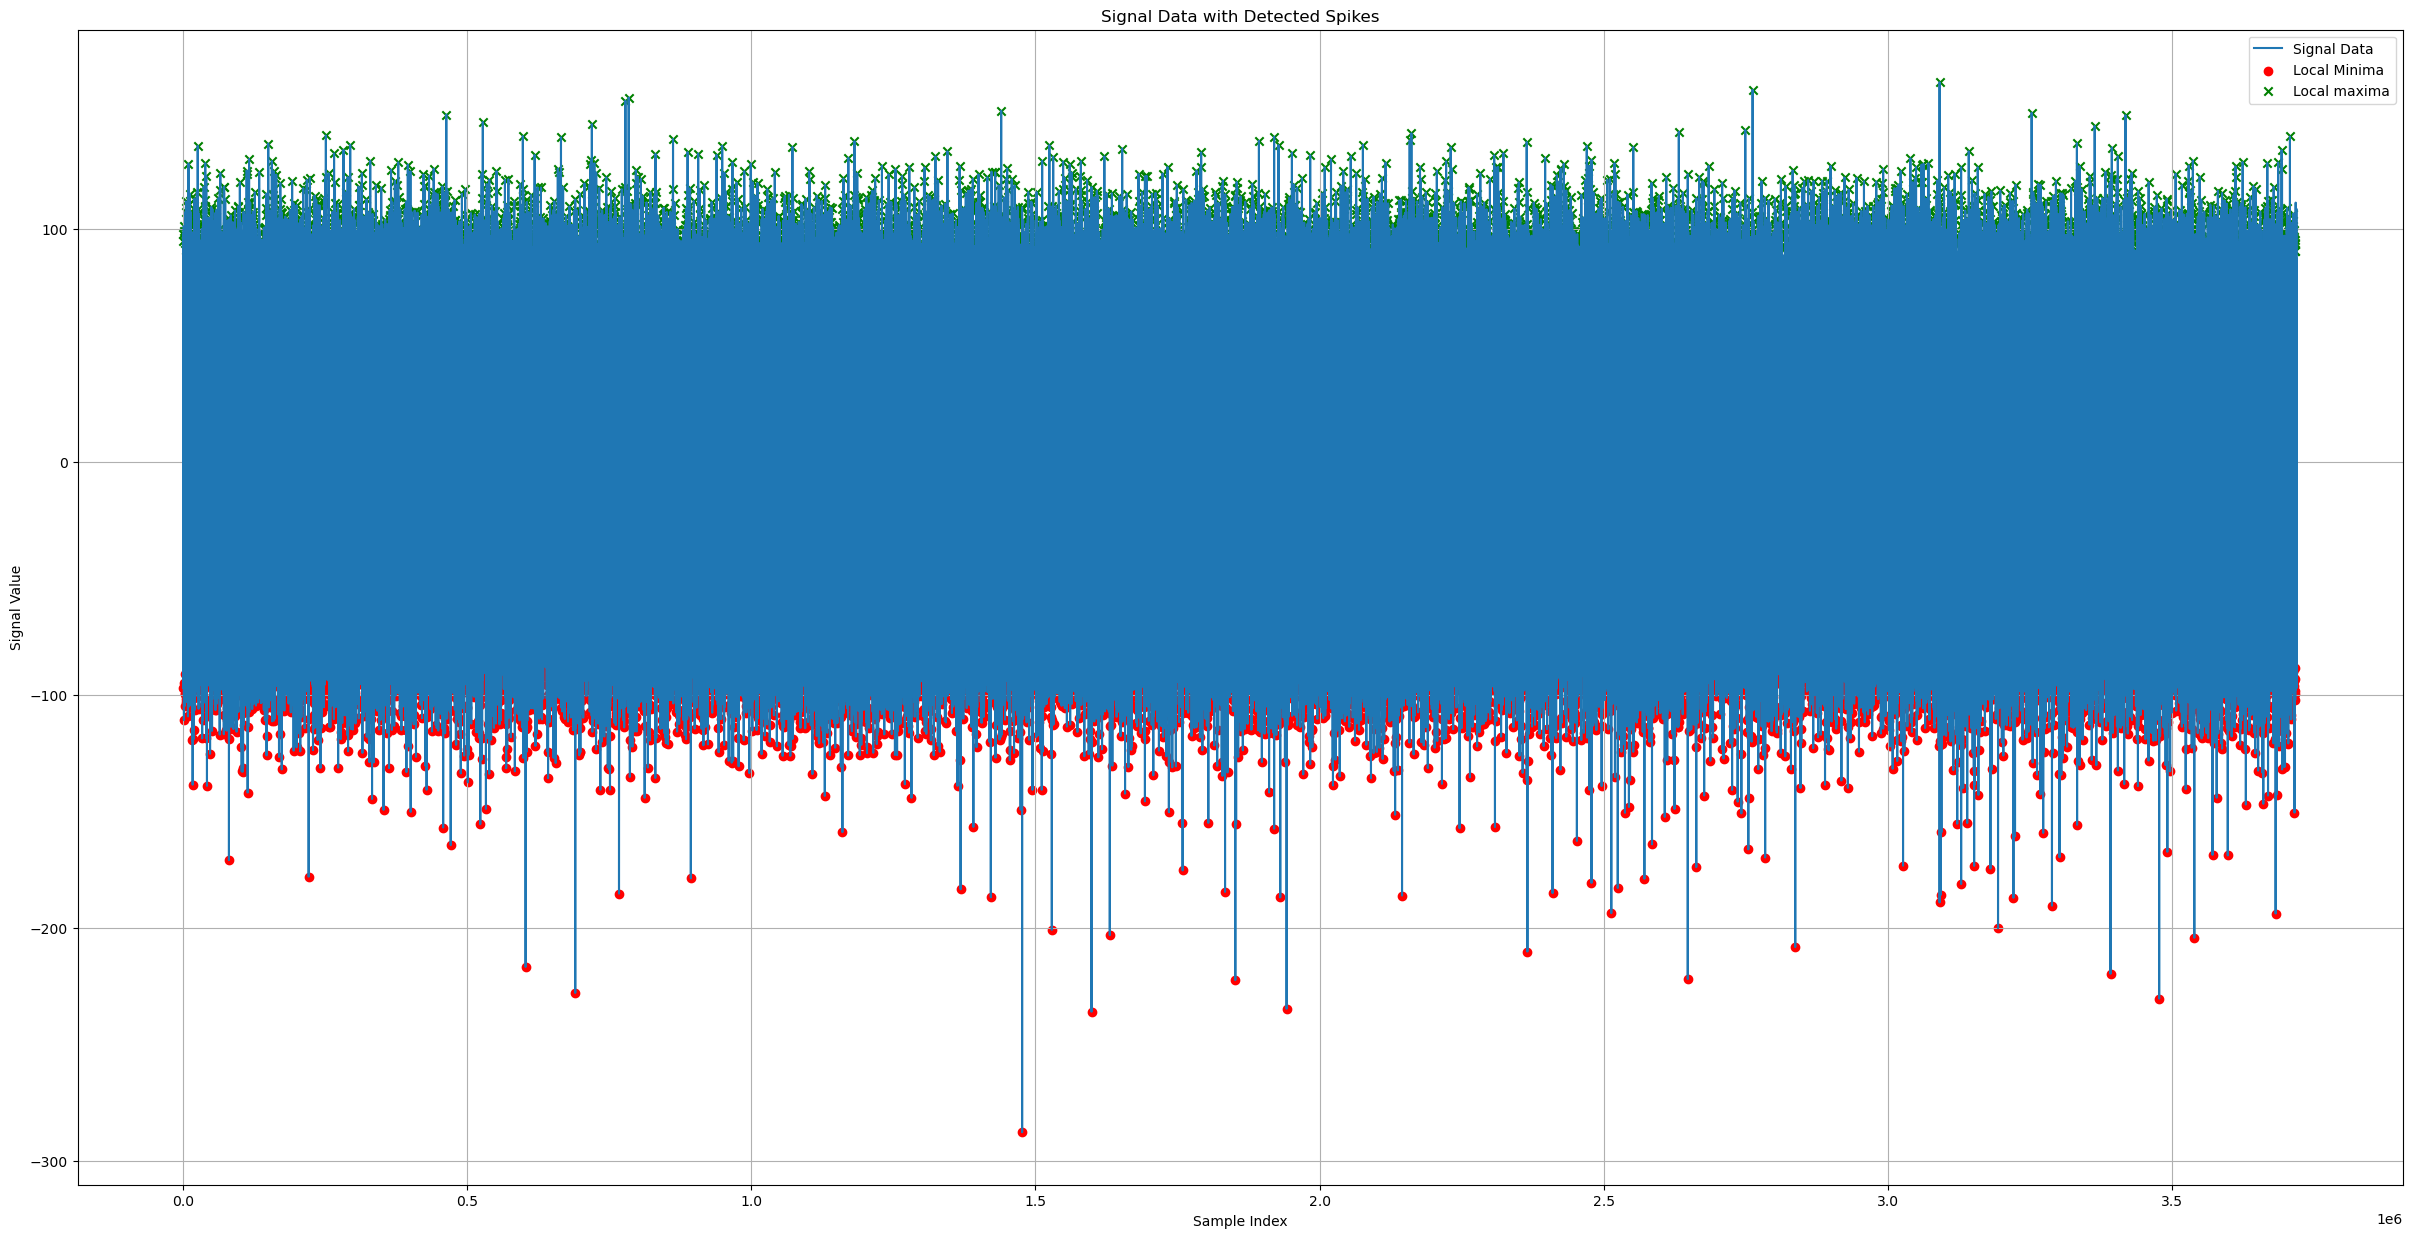

In [23]:
prova=prova_st
maxima=pos_st
minima=neg_st

plt.figure(figsize=(30, 15))
plt.plot(prova, label='Signal Data')
plt.scatter(minima, [prova[i] for i in minima], c='red', marker='o', label='Local Minima')
plt.scatter(maxima, [prova[i] for i in maxima], c='green', marker='x', label='Local maxima')
plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.title('Signal Data with Detected Spikes')
#plt.axis([0,30000,-5,5])
#plt.savefig('spikes2.jpg')
plt.show()

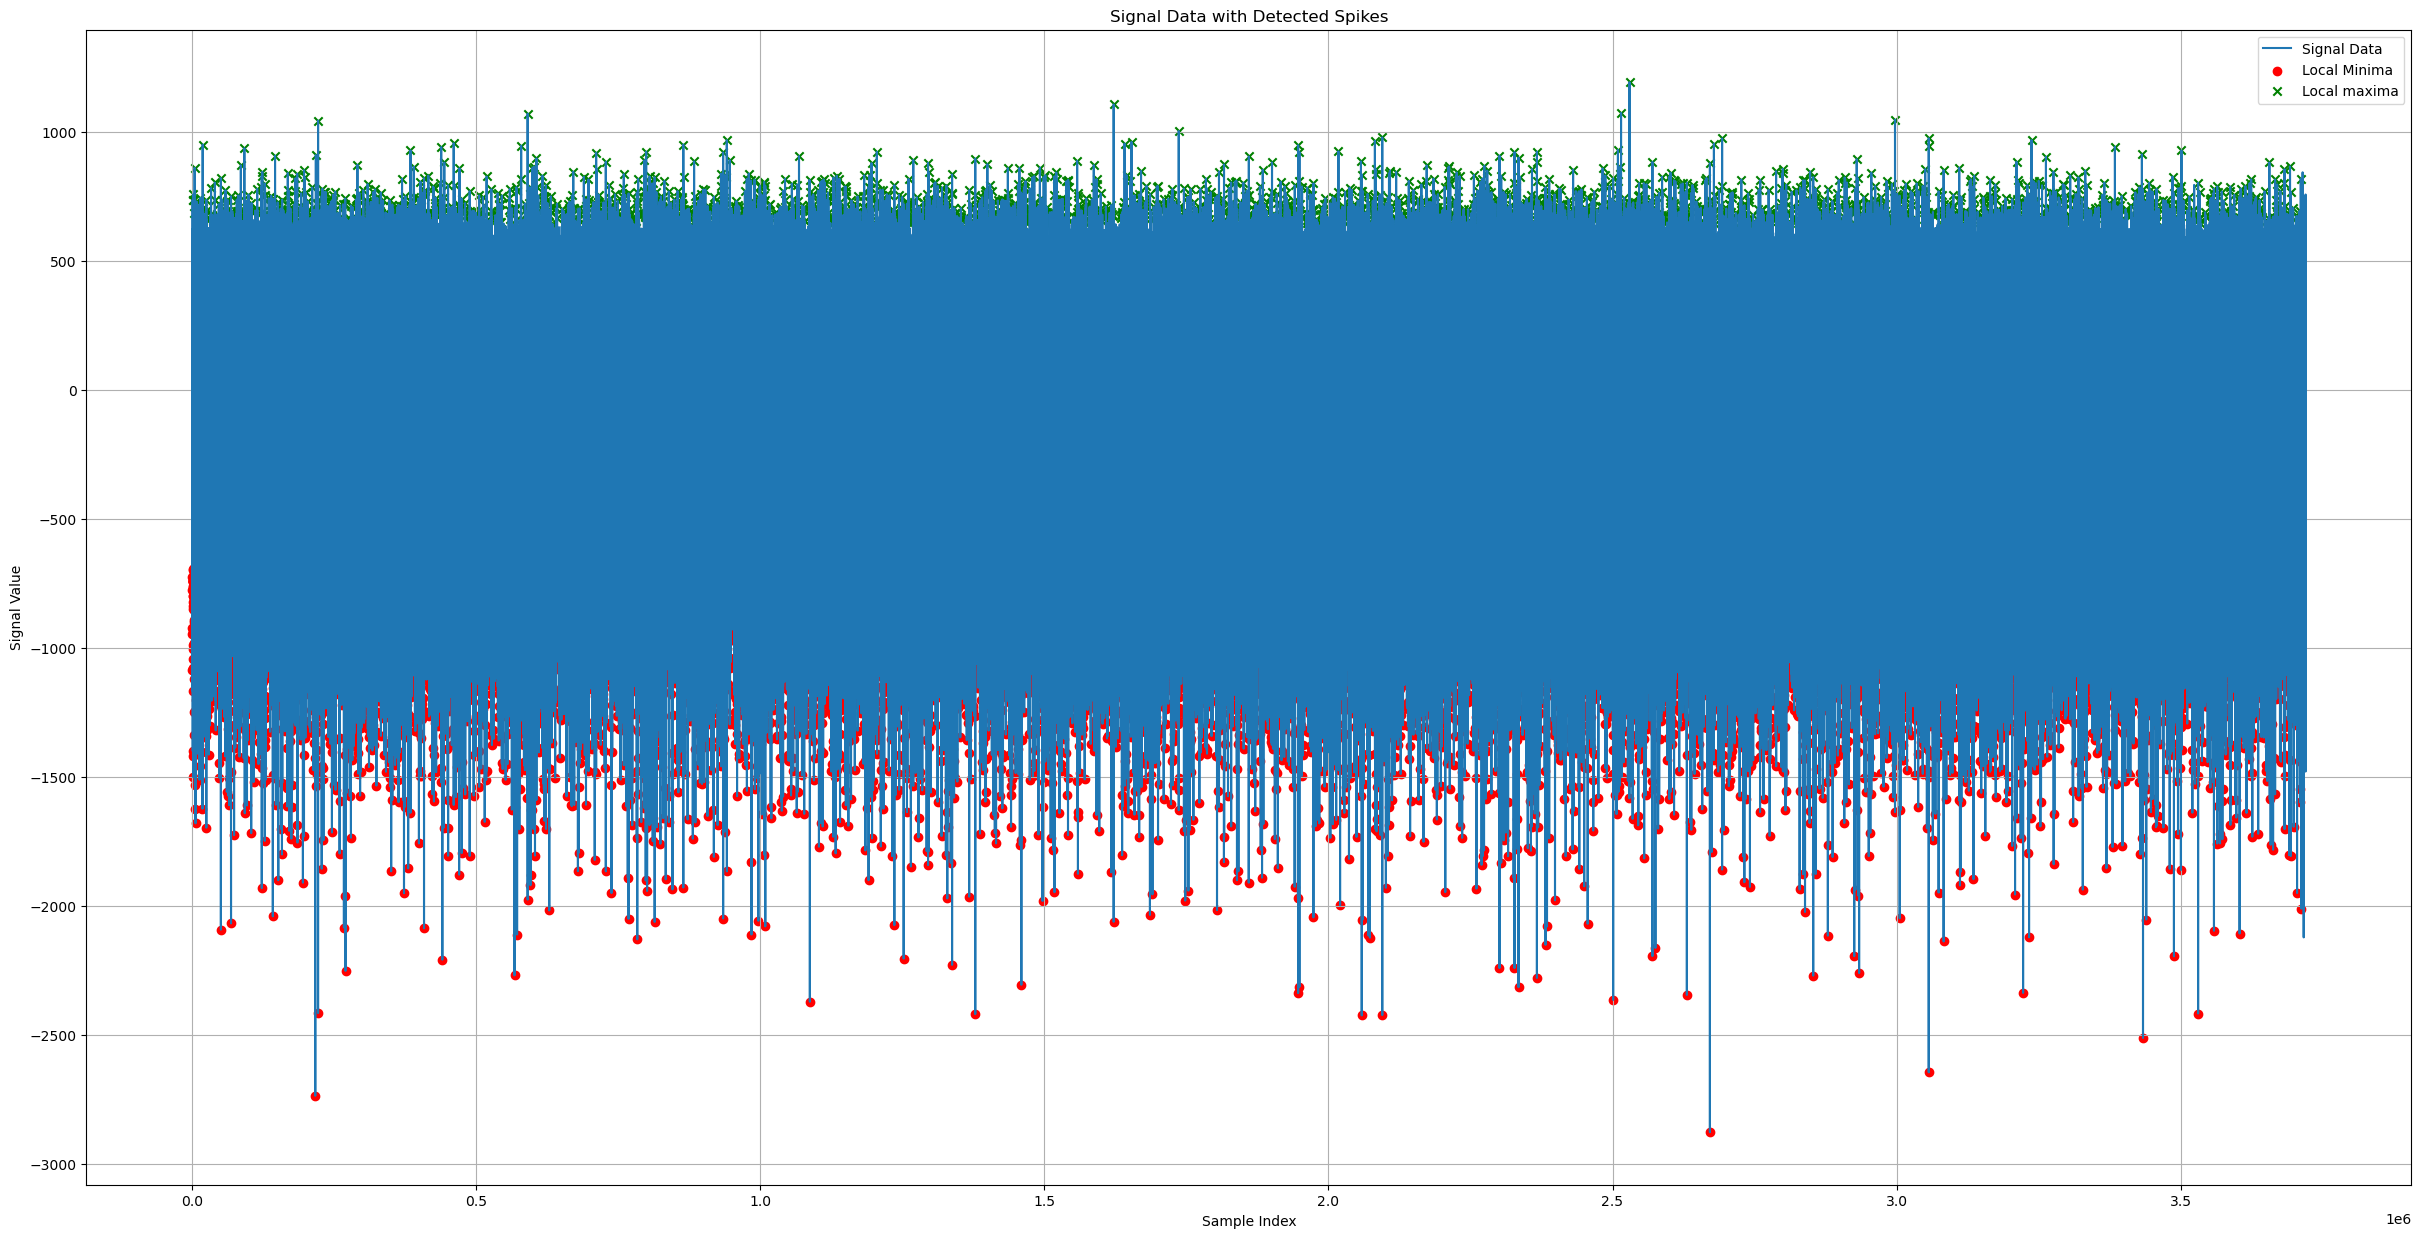

In [24]:
prova=prova_24
maxima=pos_24
minima=neg_24

plt.figure(figsize=(30, 15))
plt.plot(prova, label='Signal Data')
plt.scatter(minima, [prova[i] for i in minima], c='red', marker='o', label='Local Minima')
plt.scatter(maxima, [prova[i] for i in maxima], c='green', marker='x', label='Local maxima')
plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.title('Signal Data with Detected Spikes')
#plt.axis([0,30000,-5,5])
#plt.savefig('spikes2.jpg')
plt.show()

prova=prova_BL
pos_ind=[]
neg_ind=[]
for electrode in tqdm(prova.columns):
    channel=prova[electrode]
    pos, neg=find_all_spikes(channel)
    pos_ind_BL.append(pos)
    neg_ind_BL.append(neg)

prova=prova_st
pos_ind=[]
neg_ind=[]
for electrode in tqdm(prova.columns):
    channel=prova[electrode]
    pos, neg=find_all_spikes(channel)
    pos_ind_st.append(pos)
    neg_ind_st.append(neg)

In [11]:
pos_cut_BL,n_pos_BL, neg_cut_BL,n_neg_BL = cut(pos_BL,neg_BL,prova_BL)
pos_cut_st,n_pos_st, neg_cut_st,n_neg_st = cut(pos_st,neg_st,prova_st)
pos_cut_24,n_pos_24, neg_cut_24,n_neg_24 = cut(pos_24,neg_24,prova_24)

In [12]:
pos_cut_BL=mask_cuts(pos_cut_BL)
neg_cut_BL= mask_cuts(neg_cut_BL)

pos_cut_st=mask_cuts(pos_cut_st)
neg_cut_st= mask_cuts(neg_cut_st)

pos_cut_24=mask_cuts(pos_cut_24)
neg_cut_24= mask_cuts(neg_cut_24)

pos_cut=[]
neg_cut=[]
n_pos=[]
n_neg=[]

for i,electrode in enumerate(tqdm(prova.columns)):
    pos=pos_ind[i]
    neg=neg_ind[i]
    channel=prova[electrode]
    pos_cut1,n_pos1, neg_cut1,n_neg1 = cut(pos,neg,channel)
    pos_cut.append(pos_cut1)
    neg_cut.append(neg_cut1)
    n_pos.append(n_pos1)
    n_neg.append(n_neg1)
#savedp = copy.deepcopy(pos_cut)
#savedn = copy.deepcopy(neg_cut)

for i in (tqdm(range(len(pos_cut)))):
    pos_cut[i]=mask_cuts(pos_cut[i])
    neg_cut[i]= mask_cuts(neg_cut[i])

final_data_pos=[]
for channel in (tqdm(range(len(pos_cut)))):
    channel_clusters=clus(pos_cut[channel],'kmeans',n_pos[channel],prova.iloc[:,channel])
    final_data_pos.append(channel_clusters)

# clustering

Total spikes:  7103
For 2 clusters, the silhouette score is: 0.121
For 3 clusters, the silhouette score is: 0.156
For 4 clusters, the silhouette score is: 0.170
For 5 clusters, the silhouette score is: 0.171
For 6 clusters, the silhouette score is: 0.189
For 7 clusters, the silhouette score is: 0.204
For 8 clusters, the silhouette score is: 0.163
For 9 clusters, the silhouette score is: 0.208
For 10 clusters, the silhouette score is: 0.203


Best cluster in the range 2 to  10 :  9 , with a silhouette score of:  0.2078491531321801   


firing rate threshold:  1.1279609201345315


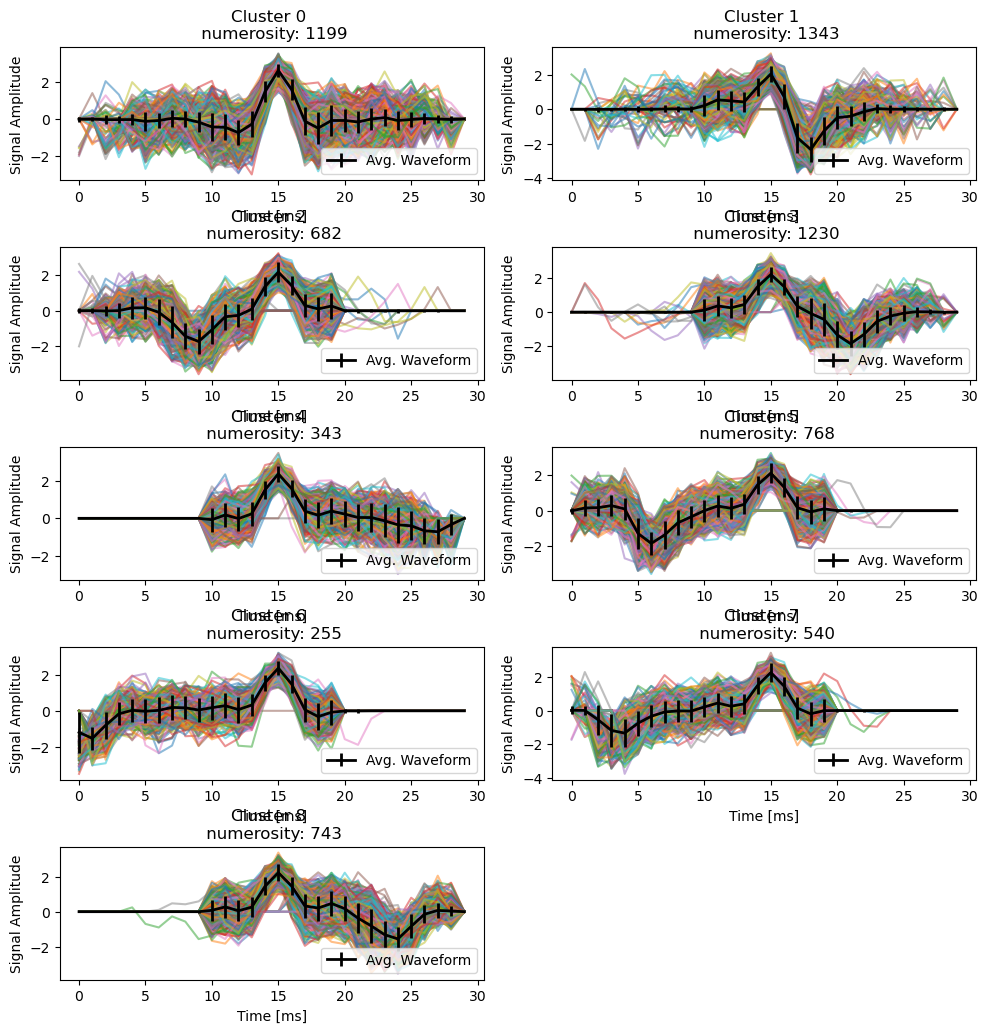

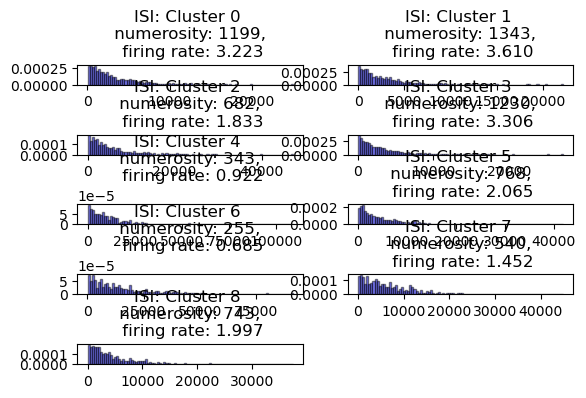

In [13]:
final_data_pos_BL= clus(pos_cut_BL,'kmeans',n_pos_BL,prova_BL)

Total spikes:  6224
For 2 clusters, the silhouette score is: 0.111
For 3 clusters, the silhouette score is: 0.121
For 4 clusters, the silhouette score is: 0.120
For 5 clusters, the silhouette score is: 0.129
For 6 clusters, the silhouette score is: 0.131
For 7 clusters, the silhouette score is: 0.136
For 8 clusters, the silhouette score is: 0.141
For 9 clusters, the silhouette score is: 0.132
For 10 clusters, the silhouette score is: 0.131


Best cluster in the range 2 to  10 :  8 , with a silhouette score of:  0.14067098113047213   


firing rate threshold:  1.6575494502945045


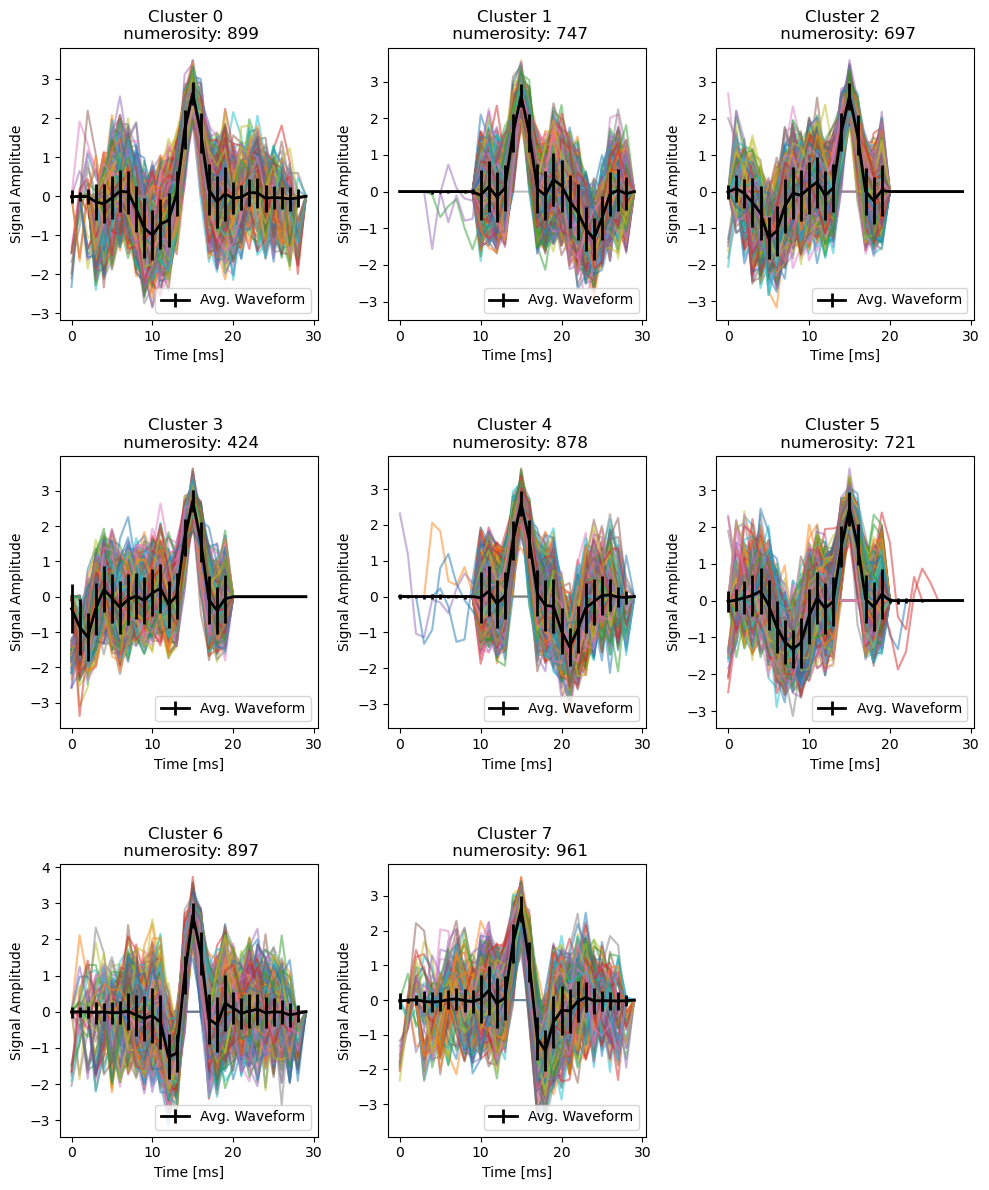

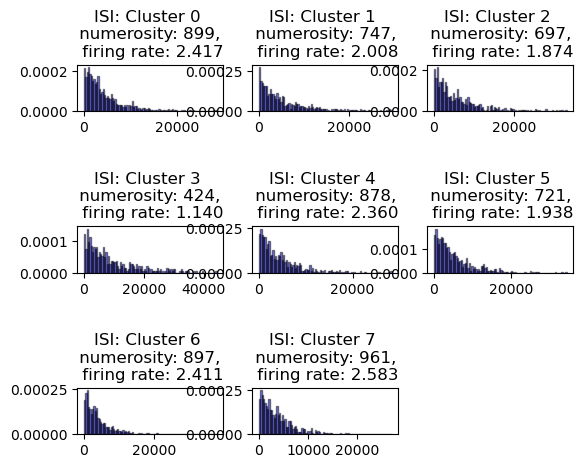

In [14]:
final_data_pos_st= clus(pos_cut_st,'kmeans',n_pos_st,prova_st)

Total spikes:  2707
For 2 clusters, the silhouette score is: 0.192
For 3 clusters, the silhouette score is: 0.178
For 4 clusters, the silhouette score is: 0.193
For 5 clusters, the silhouette score is: 0.164
For 6 clusters, the silhouette score is: 0.219
For 7 clusters, the silhouette score is: 0.193
For 8 clusters, the silhouette score is: 0.182
For 9 clusters, the silhouette score is: 0.195
For 10 clusters, the silhouette score is: 0.201


Best cluster in the range 2 to  10 :  6 , with a silhouette score of:  0.2194389394495191   


firing rate threshold:  0.7441985432249513


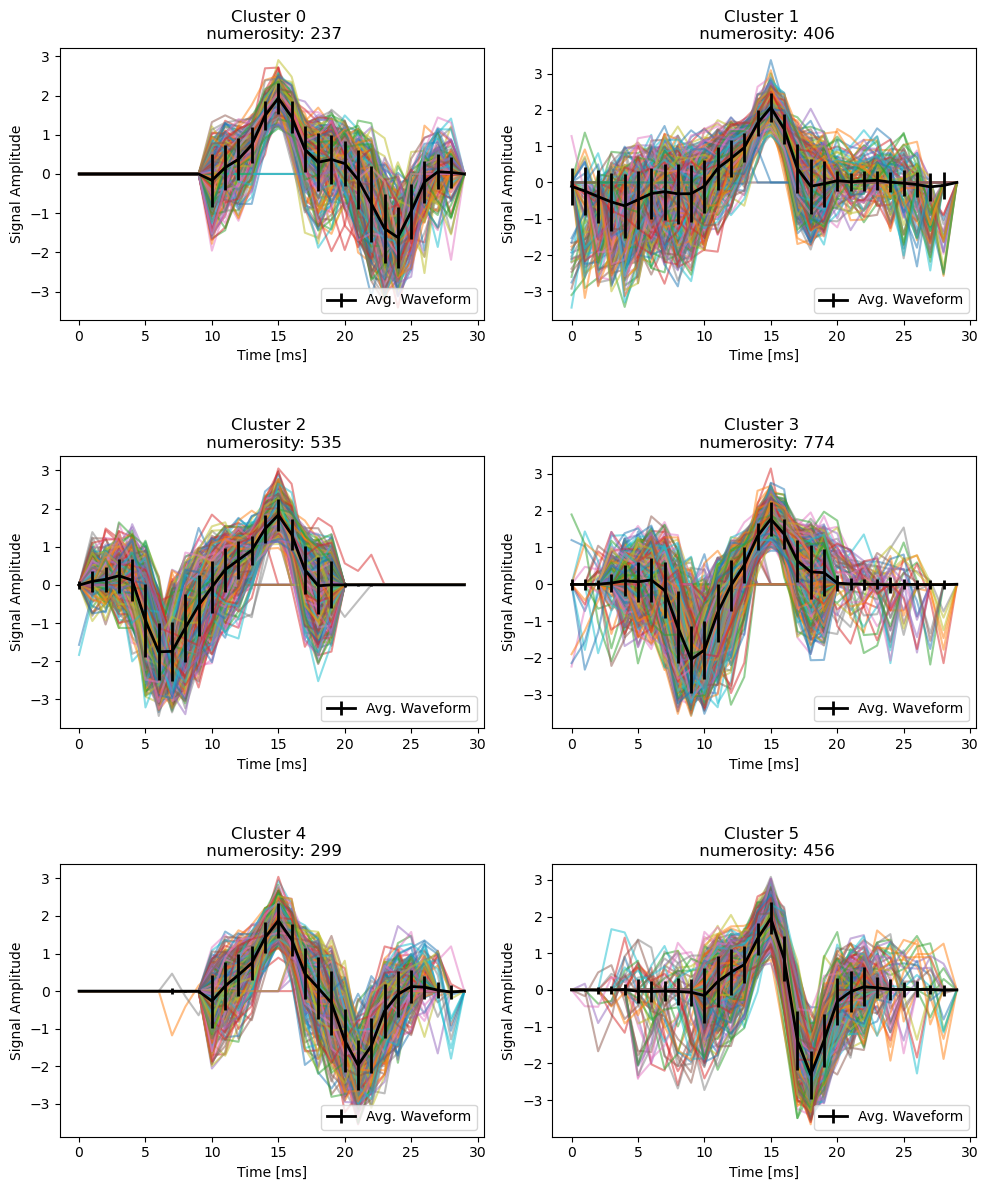

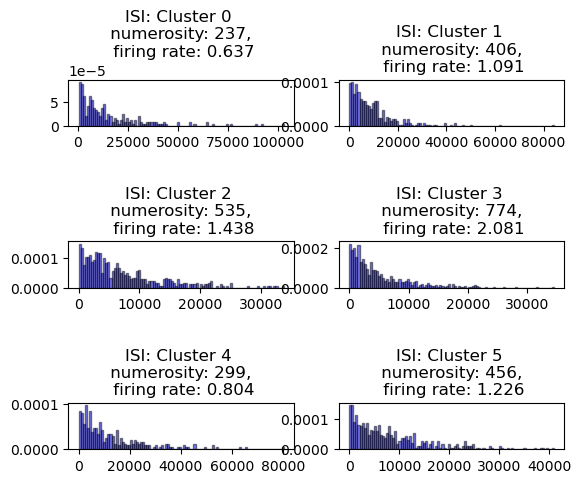

In [15]:
final_data_pos_24= clus(pos_cut_24,'kmeans',n_pos_24,prova_24)

Total spikes:  21817
For 2 clusters, the silhouette score is: 0.155
For 3 clusters, the silhouette score is: 0.145
For 4 clusters, the silhouette score is: 0.140
For 5 clusters, the silhouette score is: 0.145
For 6 clusters, the silhouette score is: 0.140
For 7 clusters, the silhouette score is: 0.133
For 8 clusters, the silhouette score is: 0.134
For 9 clusters, the silhouette score is: 0.136
For 10 clusters, the silhouette score is: 0.138


Best cluster in the range 2 to  10 :  2 , with a silhouette score of:  0.1546279388451739   


firing rate threshold:  17.827956989247312


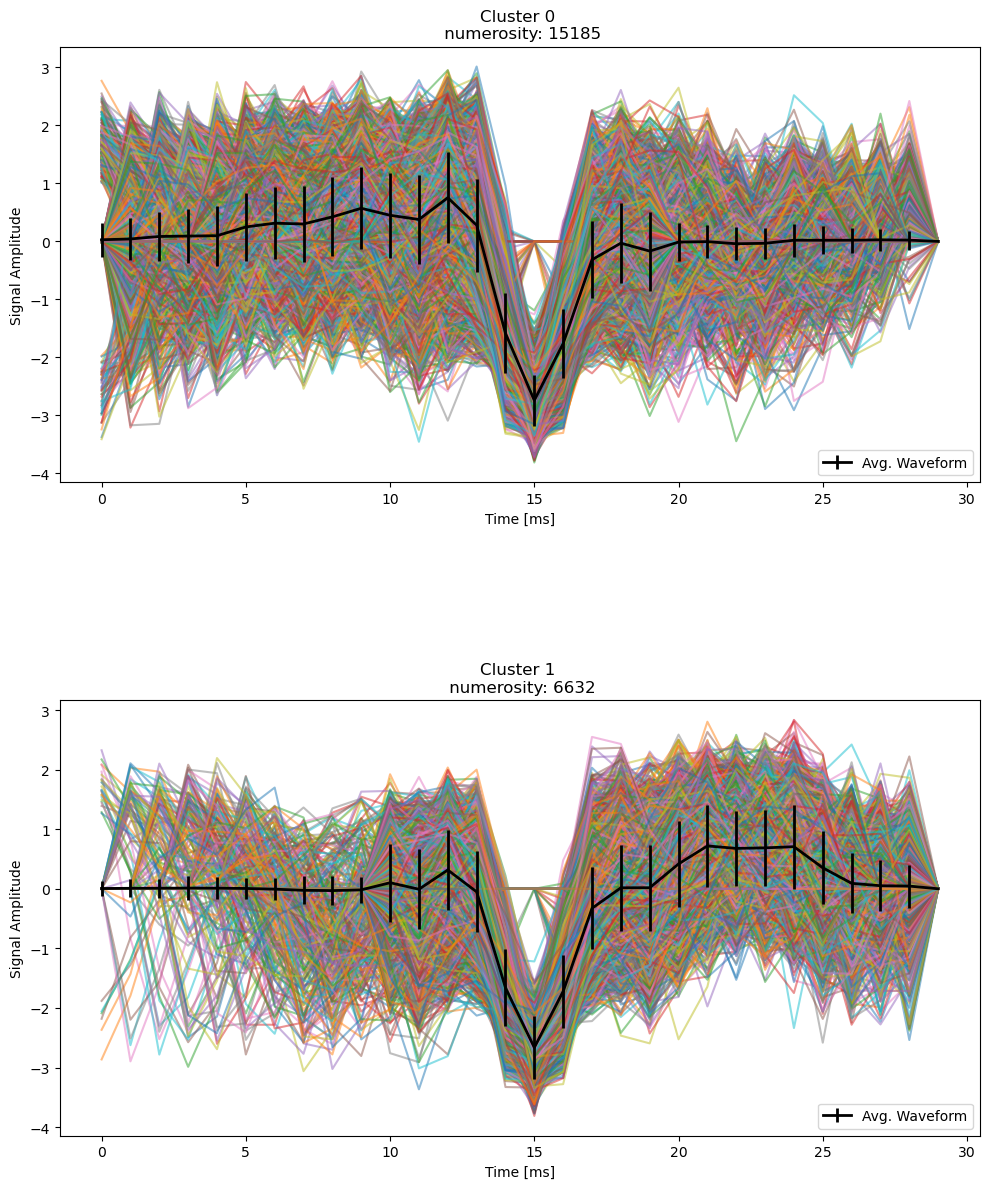

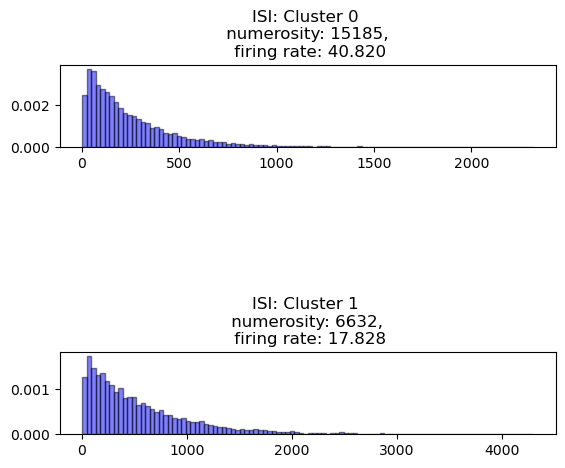

In [16]:
final_data_pos_BL= clus(neg_cut_BL,'kmeans',n_neg_BL,prova_BL)

Total spikes:  6436
For 2 clusters, the silhouette score is: 0.106
For 3 clusters, the silhouette score is: 0.121
For 4 clusters, the silhouette score is: 0.121
For 5 clusters, the silhouette score is: 0.132
For 6 clusters, the silhouette score is: 0.134
For 7 clusters, the silhouette score is: 0.135
For 8 clusters, the silhouette score is: 0.134
For 9 clusters, the silhouette score is: 0.134
For 10 clusters, the silhouette score is: 0.120


Best cluster in the range 2 to  10 :  7 , with a silhouette score of:  0.13497584221280717   


firing rate threshold:  1.6366821907217468


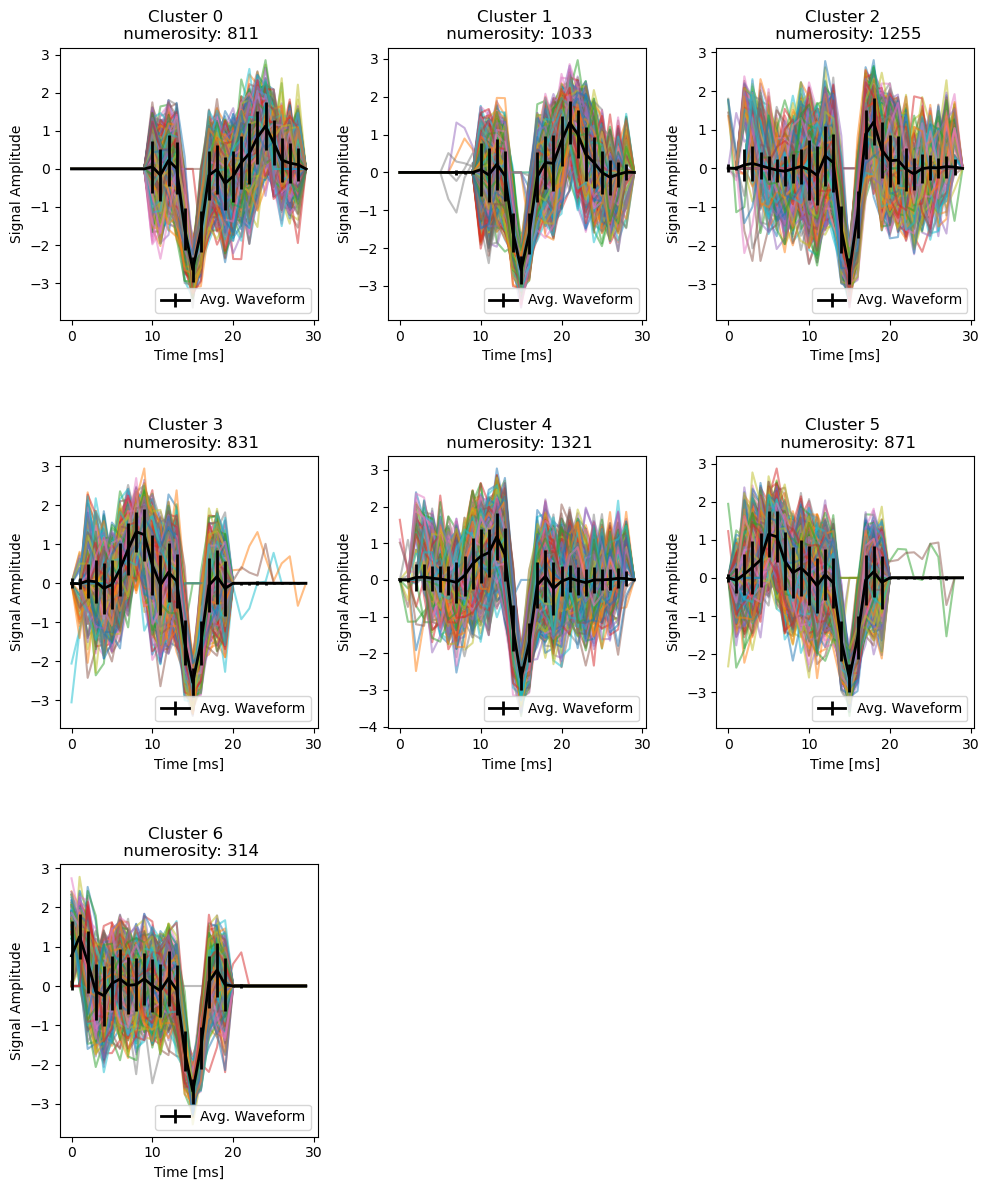

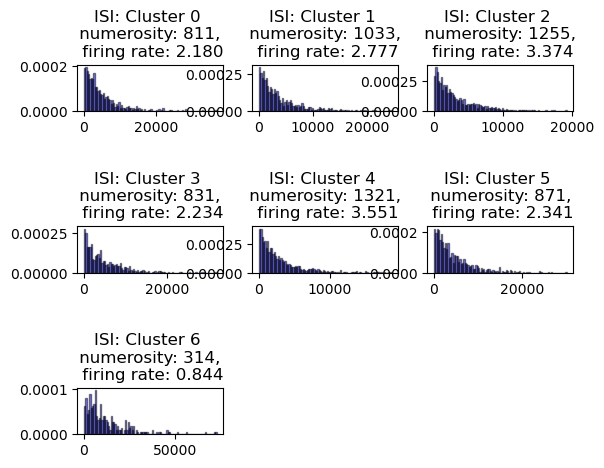

In [17]:
final_data_pos_st= clus(neg_cut_st,'kmeans',n_neg_st,prova_st)

Total spikes:  38171
For 2 clusters, the silhouette score is: 0.160
For 3 clusters, the silhouette score is: 0.166
For 4 clusters, the silhouette score is: 0.151
For 5 clusters, the silhouette score is: 0.159
For 6 clusters, the silhouette score is: 0.151
For 7 clusters, the silhouette score is: 0.151
For 8 clusters, the silhouette score is: 0.139
For 9 clusters, the silhouette score is: 0.145
For 10 clusters, the silhouette score is: 0.138


Best cluster in the range 2 to  10 :  3 , with a silhouette score of:  0.16596042054882637   


firing rate threshold:  25.93970579951465


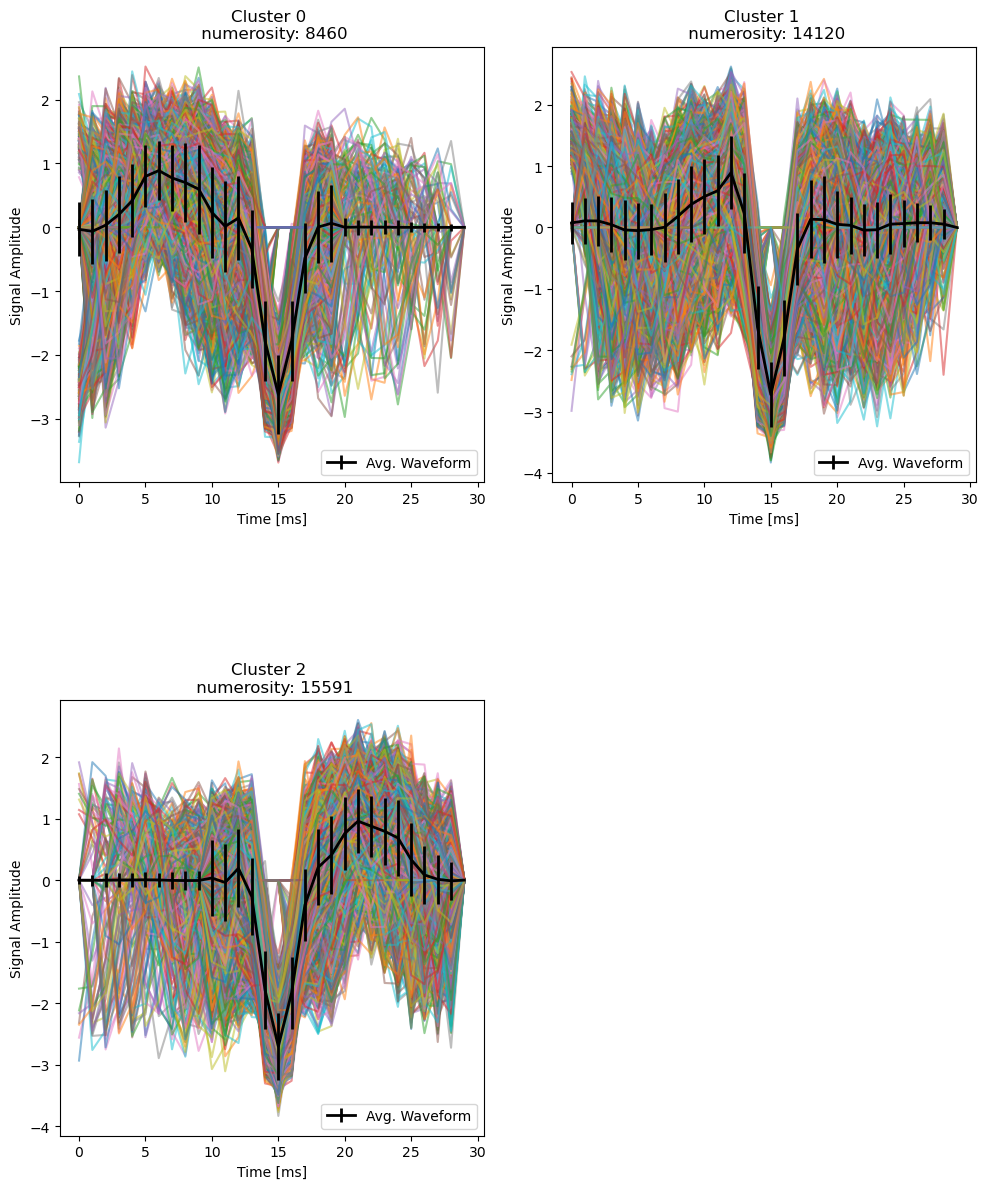

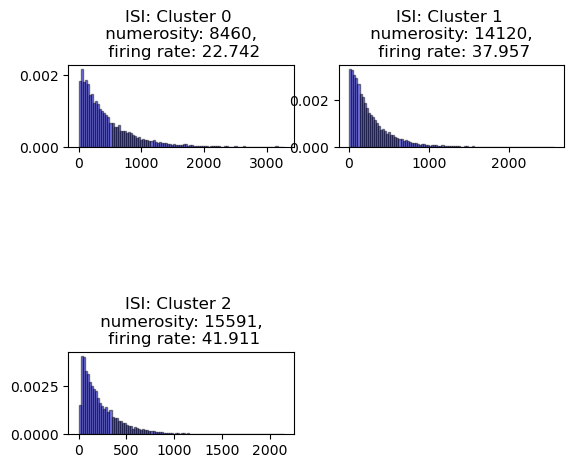

In [18]:
final_data_pos_24= clus(neg_cut_24,'kmeans',n_neg_24,prova_24)

In [ ]:
spike_list=n_pos
spike_list
print(switch_index,max(spike_list))

In [ ]:
spike_list=np.array(spike_list)
spike_list1=[]
for spike_ind in tqdm(spike_list):
    if spike_ind<=switch_index:
        spike_list1.append(spike_ind)
spike_list1=np.array(spike_list1)
end_spikelist1=len(spike_list1)-1
spike_list2=spike_list[end_spikelist1+1:]

In [ ]:
len(pos_cut)

In [ ]:
pos_cut.shape

In [ ]:
len(spike_list1)

In [ ]:
pos_cut[:end_spikelist1+1].shape

In [ ]:
#def clus(cut,clustering,spike_list,data):
cut=pos_cut
clustering='kmeans'
spike_list=n_pos
data=merge
#switch_index=
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import silhouette_score
from scipy.stats import kurtosis
import skfuzzy as fuzz
import numpy as np
import math
n_min=3
n_tries=15
spike_list=np.array(spike_list)
spike_list1=[]
for spike_ind in tqdm(spike_list):
    if spike_ind<=switch_index:
        spike_list1.append(spike_ind)
spike_list1=np.array(spike_list1)
end_spikelist1=len(spike_list1)-1
spike_list2=spike_list[end_spikelist1+1:]

len_data1=len(data[:switch_index])
len_data2=len(data[switch_index+1:])

cut1=pos_cut[:end_spikelist1]
cut2=pos_cut[end_spikelist1+1:]

scale = StandardScaler()
estratti_norm = scale.fit_transform(cut1)
print('Total spikes cut1: ', estratti_norm.shape[0])
n_comp=10
pca = PCA(n_components=n_comp)
transformed1 = pca.fit_transform(estratti_norm)

estratti_norm = scale.fit_transform(cut2)
print('Total spikes cut2: ', estratti_norm.shape[0])
n_comp=10
pca = PCA(n_components=n_comp)
transformed2 = pca.fit_transform(estratti_norm)


info1=[]
info2=[]
#list_score=[]
#DB_score=[]
best_score=[]
if clustering=='kmeans':
    for n in range (n_min,n_tries):
        model = KMeans(n_clusters=n, n_init='auto', copy_x=True, algorithm='lloyd')
        labels1 = model.fit_predict(transformed1)
        labels2 = model.fit_predict(transformed2)
        if (n != 1):
            silhouette_avg1 = silhouette_score(transformed1, labels1)
            silhouette_avg2 = silhouette_score(transformed2, labels2)
            print("For", n,"clusters, the silhouette score is:", format(silhouette_avg1, ".3f"), format(silhouette_avg2, ".3f"))
            best_score.append(silhouette_avg1+silhouette_avg2)
            #del(model)
            #del(labels)
    top_clusters = (best_score.index(max(best_score)))+n_min
    num_clusters=top_clusters
    print("\n\n\033[1;31;47mBest cluster in the range", n_min, "to ", n_tries-1, ": ",top_clusters,", with a silhouette score of: ",best_score[top_clusters-n_min], "\u001b[0m  \n\n")

    model = KMeans(n_clusters=top_clusters, n_init='auto', copy_x=True, algorithm='lloyd')
    labels1 = model.fit_predict(transformed1)
    labels2 = model.fit_predict(transformed2)
######################### 
#adesso abbiamo due clusterizzazioni con lo stesso numero di cluster e bisogna accoppiarli per identificare i neuroni

#primo clustering
final_data=[]
temporary_data=[]
labels=labels1
cut=cut1
unique_labels = np.unique(labels)
firings=np.zeros(len(unique_labels))

fig = plt.figure(figsize=(10, 12))

# Iterate over unique cluster labels
for i, cluster_label in enumerate(unique_labels):
    # Extract data points for the current cluster
    cluster_data = cut[labels == cluster_label]
    firings[i]=len(cluster_data)*10000/len_data

    # Plot the individual cluster data
    if len(unique_labels)<=2:
        size1=len(unique_labels)
        size2=1
    elif len(unique_labels)<=5:
        size1 = math.ceil(len(unique_labels)/2)
        size2=size1
    elif len(unique_labels)<=8:
        size1 = 3
        size2=math.ceil(len(unique_labels)/size1)
    else:
        size1=6
        size2=math.ceil(len(unique_labels)/size1)
    plt.subplot(size1,size2, i + 1)
    plt.plot(cluster_data.transpose(), alpha=0.5)  # Use alpha for transparency
    #print(cluster_data)
    plt.title(f'Cluster {cluster_label} \n numerosity: {len(cluster_data)}')
    plt.xlabel('Time [ms]')
    plt.ylabel('Signal Amplitude')

    # Plot the average waveform
    mean_wave = np.mean(cluster_data, axis=0)
    #info.append(f'mean clus{cluster_label}')
    info1.append(mean_wave)
    std_wave = np.std(cluster_data, axis=0)
    plt.errorbar(range(mean_wave.shape[0]), mean_wave, yerr=std_wave, color='black', linewidth=2, label='Avg. Waveform')
    plt.legend(loc='lower right')
plt.tight_layout()

####secondo clustering
final_data=[]
temporary_data=[]
labels=labels2
cut=cut2
unique_labels = np.unique(labels)
firings=np.zeros(len(unique_labels))

fig = plt.figure(figsize=(10, 12))

# Iterate over unique cluster labels
for i, cluster_label in enumerate(unique_labels):
    # Extract data points for the current cluster
    cluster_data = cut[labels == cluster_label]
    firings[i]=len(cluster_data)*10000/len_data

    # Plot the individual cluster data
    if len(unique_labels)<=2:
        size1=len(unique_labels)
        size2=1
    elif len(unique_labels)<=5:
        size1 = math.ceil(len(unique_labels)/2)
        size2=size1
    elif len(unique_labels)<=8:
        size1 = 3
        size2=math.ceil(len(unique_labels)/size1)
    else:
        size1=6
        size2=math.ceil(len(unique_labels)/size1)
    plt.subplot(size1,size2, i + 1)
    plt.plot(cluster_data.transpose(), alpha=0.5)  # Use alpha for transparency
    #print(cluster_data)
    plt.title(f'Cluster {cluster_label} \n numerosity: {len(cluster_data)}')
    plt.xlabel('Time [ms]')
    plt.ylabel('Signal Amplitude')

    # Plot the average waveform
    mean_wave = np.mean(cluster_data, axis=0)
    #info.append(f'mean clus{cluster_label}')
    info1.append(mean_wave)
    std_wave = np.std(cluster_data, axis=0)
    plt.errorbar(range(mean_wave.shape[0]), mean_wave, yerr=std_wave, color='black', linewidth=2, label='Avg. Waveform')
    plt.legend(loc='lower right')
plt.tight_layout()

########### cambiato fino a qua


In [ ]:
len(info1)

In [ ]:
##qua bisogna creare le coppie


model = KMeans(n_clusters=9, n_init='auto', copy_x=True, algorithm='lloyd')
labels = model.fit_predict(info1)
        
final_data=[]
temporary_data=[]
#labels=labels2
cut=info1
unique_labels = np.unique(labels)
firings=np.zeros(len(unique_labels))

fig = plt.figure(figsize=(10, 12))
print(labels,unique_labels)
# Iterate over unique cluster labels
for i, cluster_label in enumerate(unique_labels):
    # Extract data points for the current cluster
    cluster_data = cut[labels == cluster_label]
    firings[i]=len(cluster_data)*10000/len_data

    # Plot the individual cluster data
    if len(unique_labels)<=2:
        size1=len(unique_labels)
        size2=1
    elif len(unique_labels)<=5:
        size1 = math.ceil(len(unique_labels)/2)
        size2=size1
    elif len(unique_labels)<=8:
        size1 = 3
        size2=math.ceil(len(unique_labels)/size1)
    else:
        size1=6
        size2=math.ceil(len(unique_labels)/size1)
    plt.subplot(size1,size2, i + 1)
    plt.plot(cluster_data.transpose(), alpha=0.5)  # Use alpha for transparency
    #print(cluster_data)
    plt.title(f'Cluster {cluster_label} \n numerosity: {len(cluster_data)}')
    plt.xlabel('Time [ms]')
    plt.ylabel('Signal Amplitude')

    # Plot the average waveform
    mean_wave = np.mean(cluster_data, axis=0)
    #info.append(f'mean clus{cluster_label}')
    info1.append(mean_wave)
    std_wave = np.std(cluster_data, axis=0)
    plt.errorbar(range(mean_wave.shape[0]), mean_wave, yerr=std_wave, color='black', linewidth=2, label='Avg. Waveform')
    plt.legend(loc='lower right')
plt.tight_layout()


In [ ]:
mean_firing=np.mean(firings)
std_firing=np.std(firings)
firing_threshold=mean_firing-std_firing
print('firing rate threshold: ',firing_threshold)
info.append('firing threshold')
info.append(firing_threshold)
info.append('mean firing')
info.append(mean_firing)
plt.subplots_adjust(hspace=0.5)
plt.show()

for i in range(0,len(unique_labels)):
    ul=spike_list[labels==i]
    temporary_data.append(ul)
    fr=len(temporary_data[i])*10000/len_data
    if i != -1 and fr>firing_threshold:
        final_data.append(ul)
    plt.subplot(size1, size2, i + 1)
    plt.hist(np.diff(ul), bins=100, density=True, alpha=0.5, color='blue', edgecolor='black')
    plt.title(f'ISI: Cluster {i} \n numerosity: {len(temporary_data[i])}, \n firing rate: {format(len(temporary_data[i])*10000/len_data, ".3f")}')
plt.subplots_adjust(hspace=2.5)
plt.show()
del(unique_labels)
return final_data


In [ ]:
final_data_pos= clus(pos_cut,'kmeans',n_pos,merge)

In [ ]:
final_data_neg=[]

for channel in (tqdm(range(len(neg_cut)))):
    channel_clusters=clus(neg_cut[channel],'kmeans',n_neg[channel],prova.iloc[:,channel])
    final_data_neg.append(channel_clusters)